<a href="https://colab.research.google.com/github/rendalamili/ml-for-table-extraction/blob/main/Pipeline_for_PDF_Documents_Using_YOLO_and_Table_Transformer_and_Comparison_with_EasyOCR_and_TesseractOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Resources

### Articles and Tutorials:
https://iamrajatroy.medium.com/document-intelligence-series-part-1-table-detection-with-yolo-1fa0a198fd7

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Using_Table_Transformer_for_table_detection_and_table_structure_recognition.ipynb

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Inference_with_Table_Transformer_(TATR)_for_parsing_tables.ipynb

### Documentation and Repositories:
https://huggingface.co/transformers/
https://huggingface.co/foduucom/table-detection-and-extraction
https://docs.ultralytics.com/
https://huggingface.co/docs/transformers/index
https://github.com/JaidedAI/EasyOCR
https://github.com/tesseract-ocr/tesseract
https://github.com/PaddlePaddle/PaddleOCR
https://github.com/ultralytics/yolov5

### Other
https://numpy.org/doc/stable/
https://pandas.pydata.org/docs/
https://matplotlib.org/stable/contents.html
https://pillow.readthedocs.io/en/stable/
https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html
https://pillow.readthedocs.io/en/stable/reference/ImageFont.html
https://pytorch.org/docs/stable/index.html

## Install Packages and Import Libaries

In [1]:
# Install the required packages
!pip install ultralyticsplus==0.0.28 ultralytics==8.0.43 pdf2image matplotlib
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
# Import required Libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from pdf2image import convert_from_path
from google.colab import files
from ultralyticsplus import YOLO, render_result
from transformers import DetrImageProcessor, TableTransformerForObjectDetection

## Table Detection

### Including selecting PDF


In [3]:
# Load the yOLO model for table detection
yolo_model = YOLO('keremberke/yolov8m-table-extraction')
yolo_model.overrides['conf'] = 0.25  # NMS confidence threshold
yolo_model.overrides['iou'] = 0.45  # NMS IoU threshold
yolo_model.overrides['agnostic_nms'] = False  # NMS class-agnostic
yolo_model.overrides['max_det'] = 1000  # Maximum detections per image

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:340: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be f

In [4]:
# Display options for pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
# Define colors
colours = {
    "table": (int(0.000 * 255), int(0.447 * 255), int(0.741 * 255)),  # Blue
    "table row": (int(0.850 * 255), int(0.325 * 255), int(0.098 * 255)),  # Orange
    "table column": (int(0.929 * 255), int(0.694 * 255), int(0.125 * 255)),  # Yellow
    "table cell": (int(0.494 * 255), int(0.184 * 255), int(0.556 * 255)),  # Purple
    "other": (int(0.466 * 255), int(0.674 * 255), int(0.188 * 255)),  # Green (default for any other label)
}

# Visualise the bounding boxes and labels
def plot_boxes_with_colours(pil_img, scores, labels, boxes, color_map=colours):
    img_copy = pil_img.convert("RGB")
    draw = ImageDraw.Draw(img_copy)

    # Load font
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    # Draw the bounding boxes with labels and scores on the image
    for score, label, (xmin, ymin, xmax, ymax) in zip(scores.tolist(), labels.tolist(), boxes.tolist()):
        # Get the labels name
        label_name = model.config.id2label.get(label, "other")

        # Choose the color based on the label, default to "other" colour if not found
        color = color_map.get(label_name, color_map["other"])

        # Draw the rectangle and the labels
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)
        text = f"{label_name}: {score:.2f}"
        text_bbox = draw.textbbox((xmin, ymin), text, font=font)
        draw.rectangle([xmin, ymin - text_bbox[3] + text_bbox[1], xmin + text_bbox[2] - text_bbox[0], ymin], fill="black")
        draw.text((xmin, max(0, ymin - (text_bbox[3] - text_bbox[1]))), text, fill="white", font=font)

    # Display the image with annotations
    display(img_copy)

In [31]:
pdf_file = '/content/Merged Cell Table.pdf'

In [32]:
# Convert the PDF to images
pages = convert_from_path(pdf_file, dpi=300)
img = pages[0]

In [33]:
# YOLO inference
yolo_results = yolo_model.predict(img)


0: 640x512 1 borderless, 28.8ms
Speed: 1.5ms preprocess, 28.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


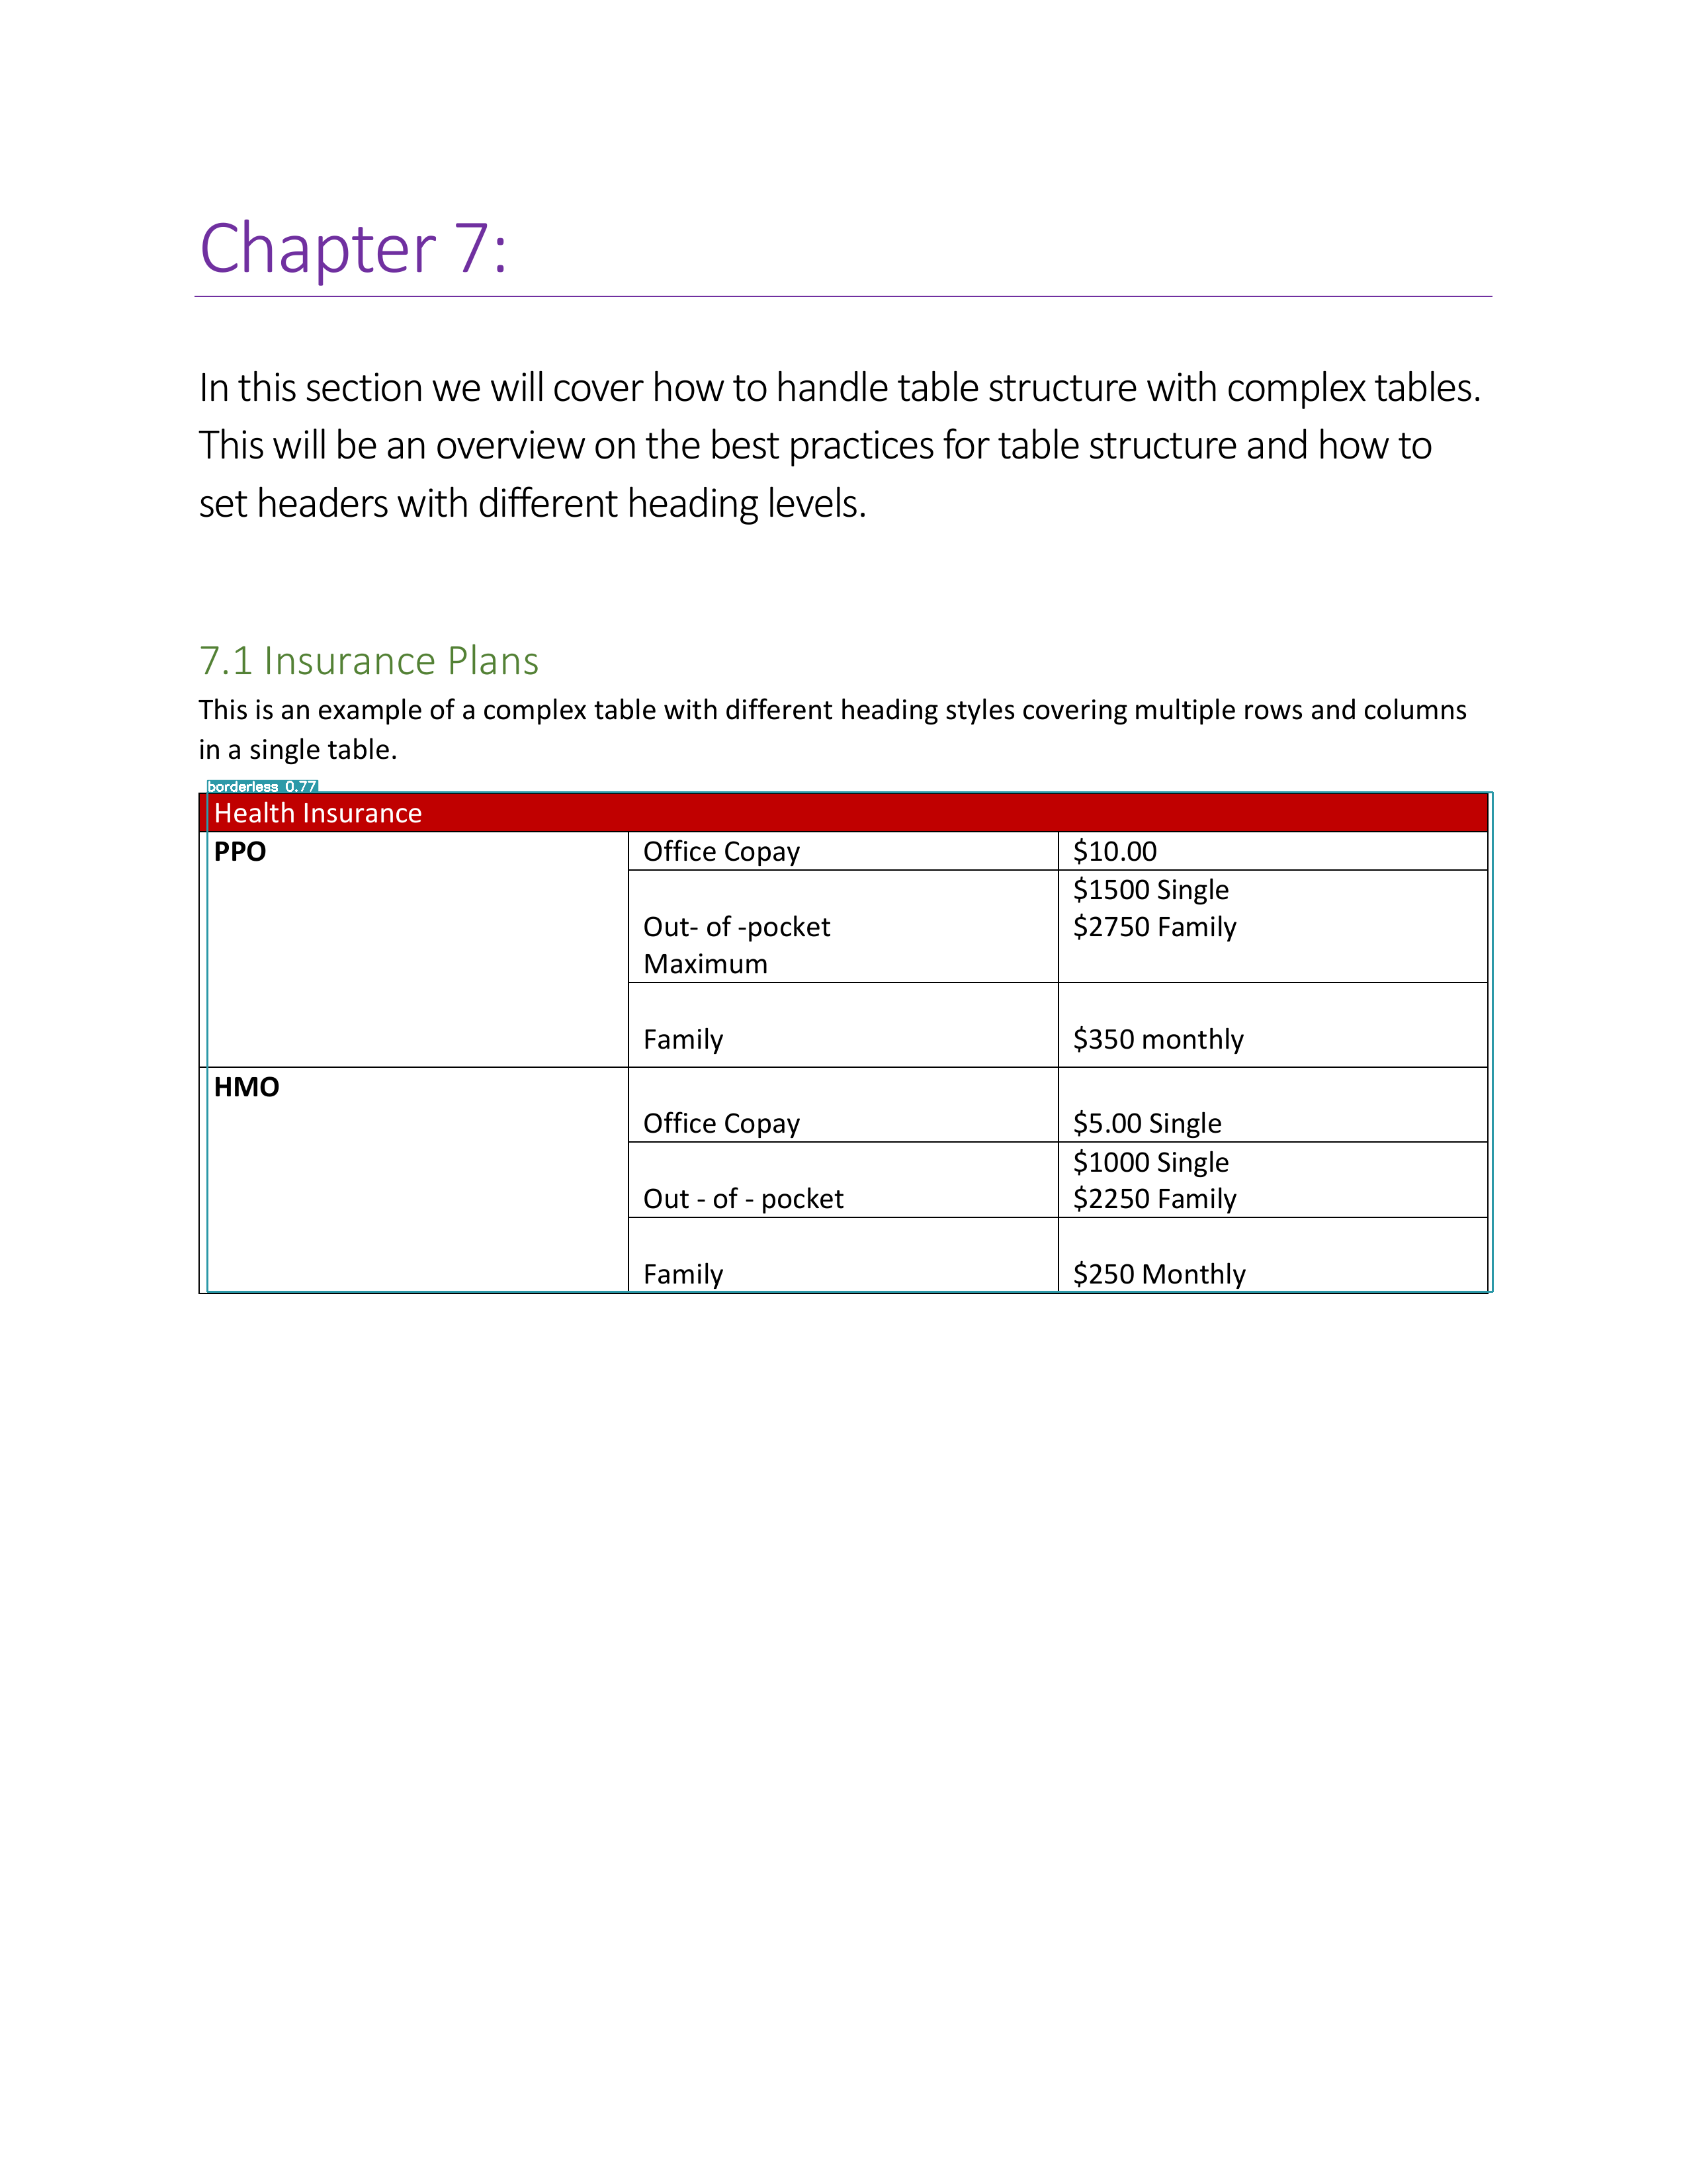

In [34]:
# Display results
render = render_result(model=yolo_model, image=img, result=yolo_results[0])
render

## Cropping

Displaying cropped table 1


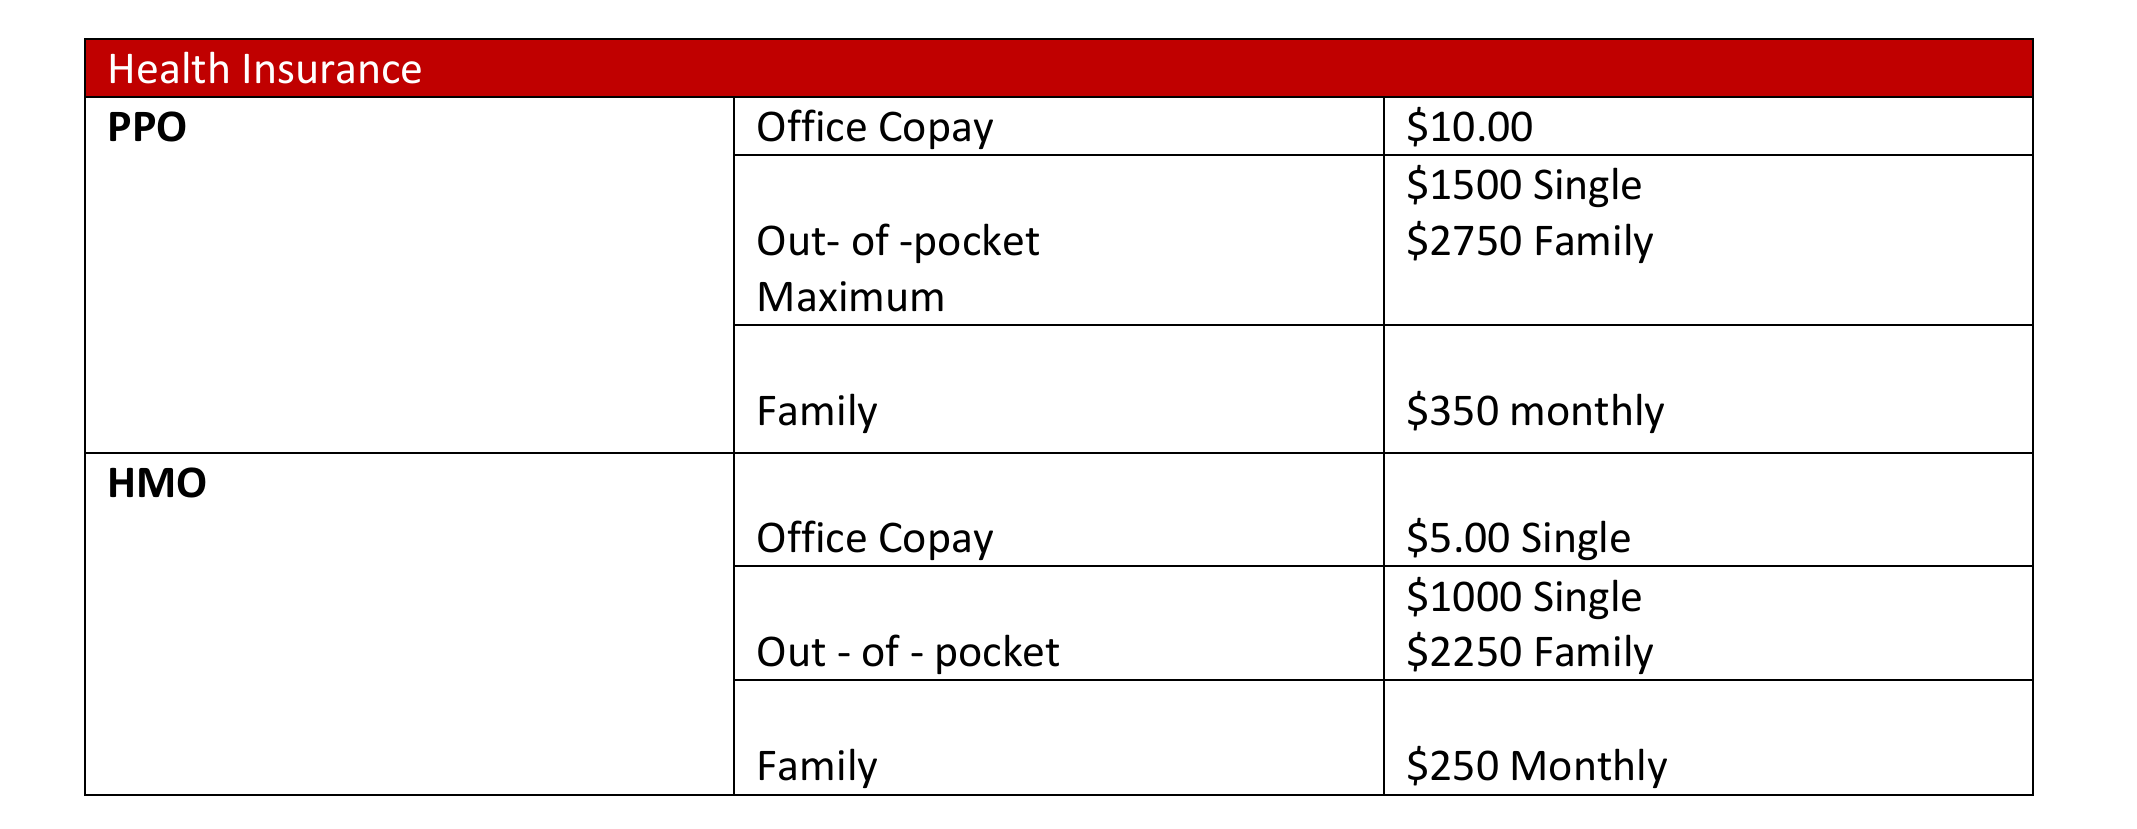

In [35]:
# Crop the table with dynamic padding based on the box dimensions from YOLO
def crop_table_with_dynamic_padding(image, box, padding_ratio=0.05):
    x_min, y_min, x_max, y_max = [int(coord) for coord in box.xyxy[0].tolist()]
    width, height = x_max - x_min, y_max - y_min

    # Calculate padding as a percentage of the detected table dimensions
    padding_x = int(width * padding_ratio)
    padding_y = int(height * padding_ratio)

    # Apply padding with boundary checks
    x_min, y_min = max(0, x_min - padding_x), max(0, y_min - padding_y)
    x_max, y_max = min(image.width, x_max + padding_x), min(image.height, y_max + padding_y)

    # Crop the image
    return image.crop((x_min, y_min, x_max, y_max))

# Crop detected tables based on dynamic padding
cropped_tables = []
for i, box in enumerate(yolo_results[0].boxes):
    cropped_table = crop_table_with_dynamic_padding(img, box)
    cropped_tables.append(cropped_table)
    print(f"Displaying cropped table {i + 1}")
    display(cropped_table)


## Structure Recognition

In [11]:
# Initialise the Table Transformer model for structure recognition
processor = DetrImageProcessor.from_pretrained("microsoft/table-transformer-structure-recognition")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition-v1.1-all")

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


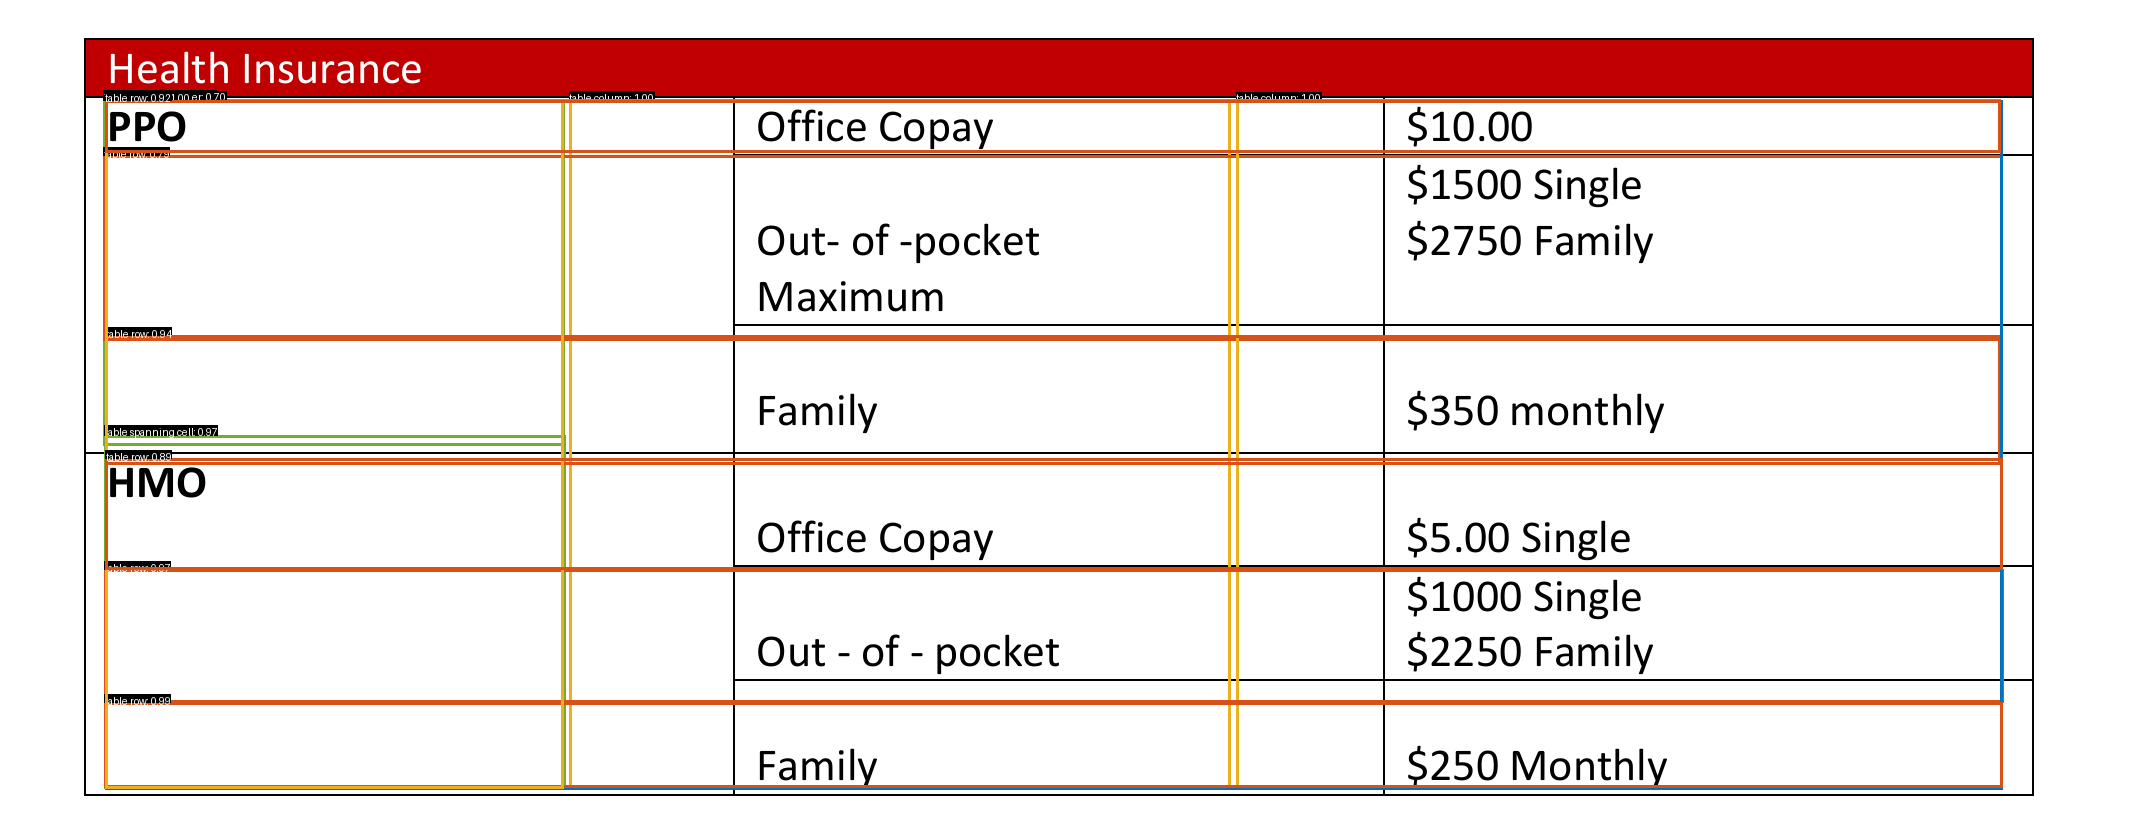

Blue = Table
Orange = Table Row
Yellow = Table Column
Purple = Table Cell
Green = Other (default for any other label)


In [36]:
# Perform structure recognition on cropped table and render results
for i, cropped_table in enumerate(cropped_tables):
    encoding = processor(images=cropped_table, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)

    # Post-process the output to get bounding boxes, labels, and scores
    target_sizes = [cropped_table.size[::-1]]
    results = processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]

    # Render detected table structure on the image
    scores, labels, boxes = results["scores"], results["labels"], results["boxes"]
    plot_boxes_with_colours(cropped_table, scores, labels, boxes)

print("Blue = Table")
print("Orange = Table Row")
print("Yellow = Table Column")
print("Purple = Table Cell")
print("Green = Other (default for any other label)")

## OCR

In [13]:
!pip install numpy
!pip install tqdm


In [37]:
# Get cell coordinates by row
def get_cell_coordinates_by_row(table_data):
    # Extract and sort rows and columns based on labels
    rows = sorted(
        [box for box, label in zip(table_data['boxes'], table_data['labels']) if label == model.config.label2id['table row']],
        key=lambda x: x[1]  # Sort by ymin
    )
    columns = sorted(
        [box for box, label in zip(table_data['boxes'], table_data['labels']) if label == model.config.label2id['table column']],
        key=lambda x: x[0]  # Sort by xmin
    )

    # Generate cell coordinates
    cell_coordinates = [
        {
            'row': row,
            'cells': [{'column': column, 'cell': (column[0], row[1], column[2], row[3])} for column in columns]
        }
        for row in rows
    ]

    # Sort cells within each row by X coordinate (xmin)
    for row_data in cell_coordinates:
        row_data['cells'].sort(key=lambda x: x['cell'][0])

    return cell_coordinates

# Get cell coordinates
cell_coordinates = get_cell_coordinates_by_row({'boxes': boxes, 'labels': labels})

### EasyOCR

In [15]:
!pip install easyocr

import numpy as np
import easyocr
from tqdm.auto import tqdm # Progress Bar

# Initialise EasyOCR reader
reader = easyocr.Reader(['en'])

Applying EasyOCR:   0%|          | 0/6 [00:00<?, ?it/s]

['PPO', 'Office Copay', 'S10.00']
['', 'Out- of -pocket Maximum', 'S1500 Single S2750 Family']
['', 'Family', 'S350 monthly']
['HMO', 'Office Copay', 'S5.00 Single']
['', 'Out of pocket', 'S1000 Single S2250 Family']
['', 'Family', 'S250 Monthly']


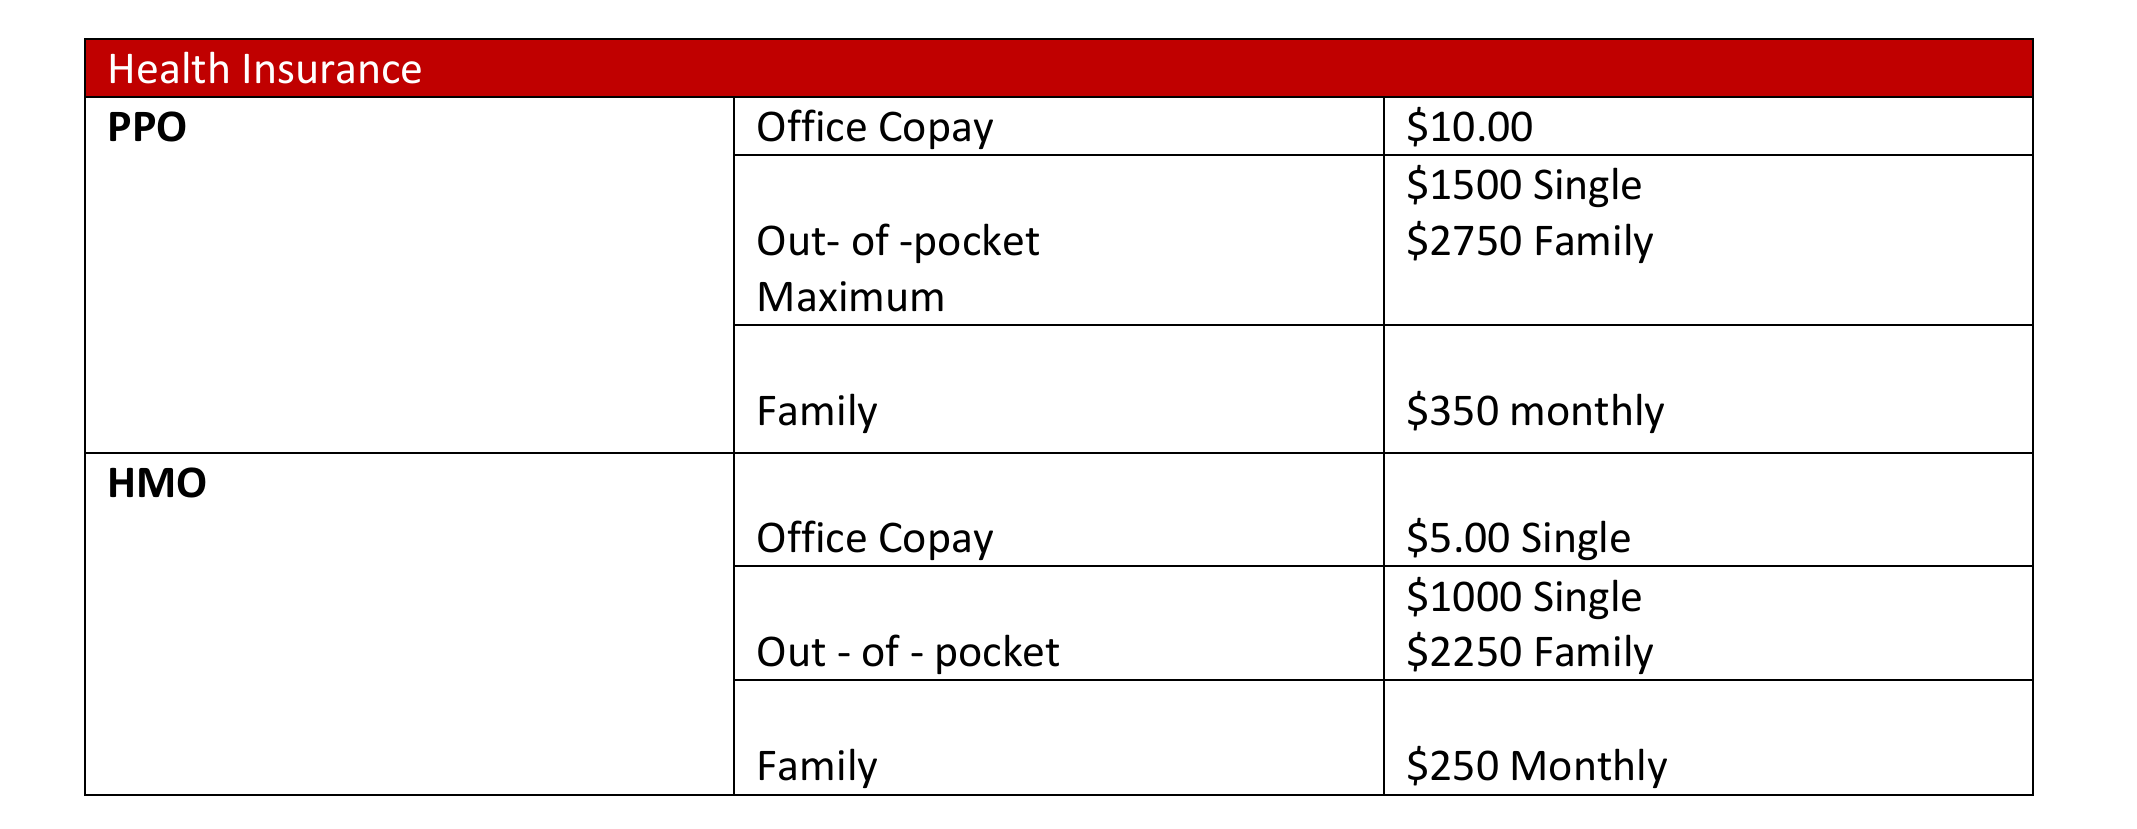

In [38]:
# Function to apply OCR row by row on cell coordinates
def apply_easy_ocr(cell_coordinates, cropped_table_image):
    data = {}
    max_num_columns = 0

    # Apply OCR for each row of cell coordinates
    for idx, row_data in enumerate(tqdm(cell_coordinates, desc="Applying EasyOCR")):
        row_text = [
            " ".join([x[1] for x in reader.readtext(np.array(cropped_table_image.crop((int(x_min), int(y_min), int(x_max), int(y_max)))))])
            for x_min, y_min, x_max, y_max in [cell['cell'] for cell in row_data['cells']]
        ]

        max_num_columns = max(max_num_columns, len(row_text))
        data[idx] = row_text

    return data

# OCR
data = apply_easy_ocr(cell_coordinates, cropped_table)

# Print results row by row
for row, row_data in data.items():
    print(row_data)

display(cropped_table)


### Tesseract OCR

In [17]:
!pip install pytesseract
!apt-get install -y tesseract-ocr
import pytesseract
from PIL import Image
from tqdm.auto import tqdm #Progress Bar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Applying OCR with Tesseract:   0%|          | 0/6 [00:00<?, ?it/s]

['PPO', '| Office Copay', '| $10.00']
['', 'Out- of -pocket\nMaximum', '$1500 Single\n$2750 Family']
['', 'Family', '$350 monthly']
['HMO', 'Office Copay', '$5.00 Single']
['', 'Out - of - pocket', '$1000 Single\n$2250 Family']
['', '| Family', '| $250 Monthly']


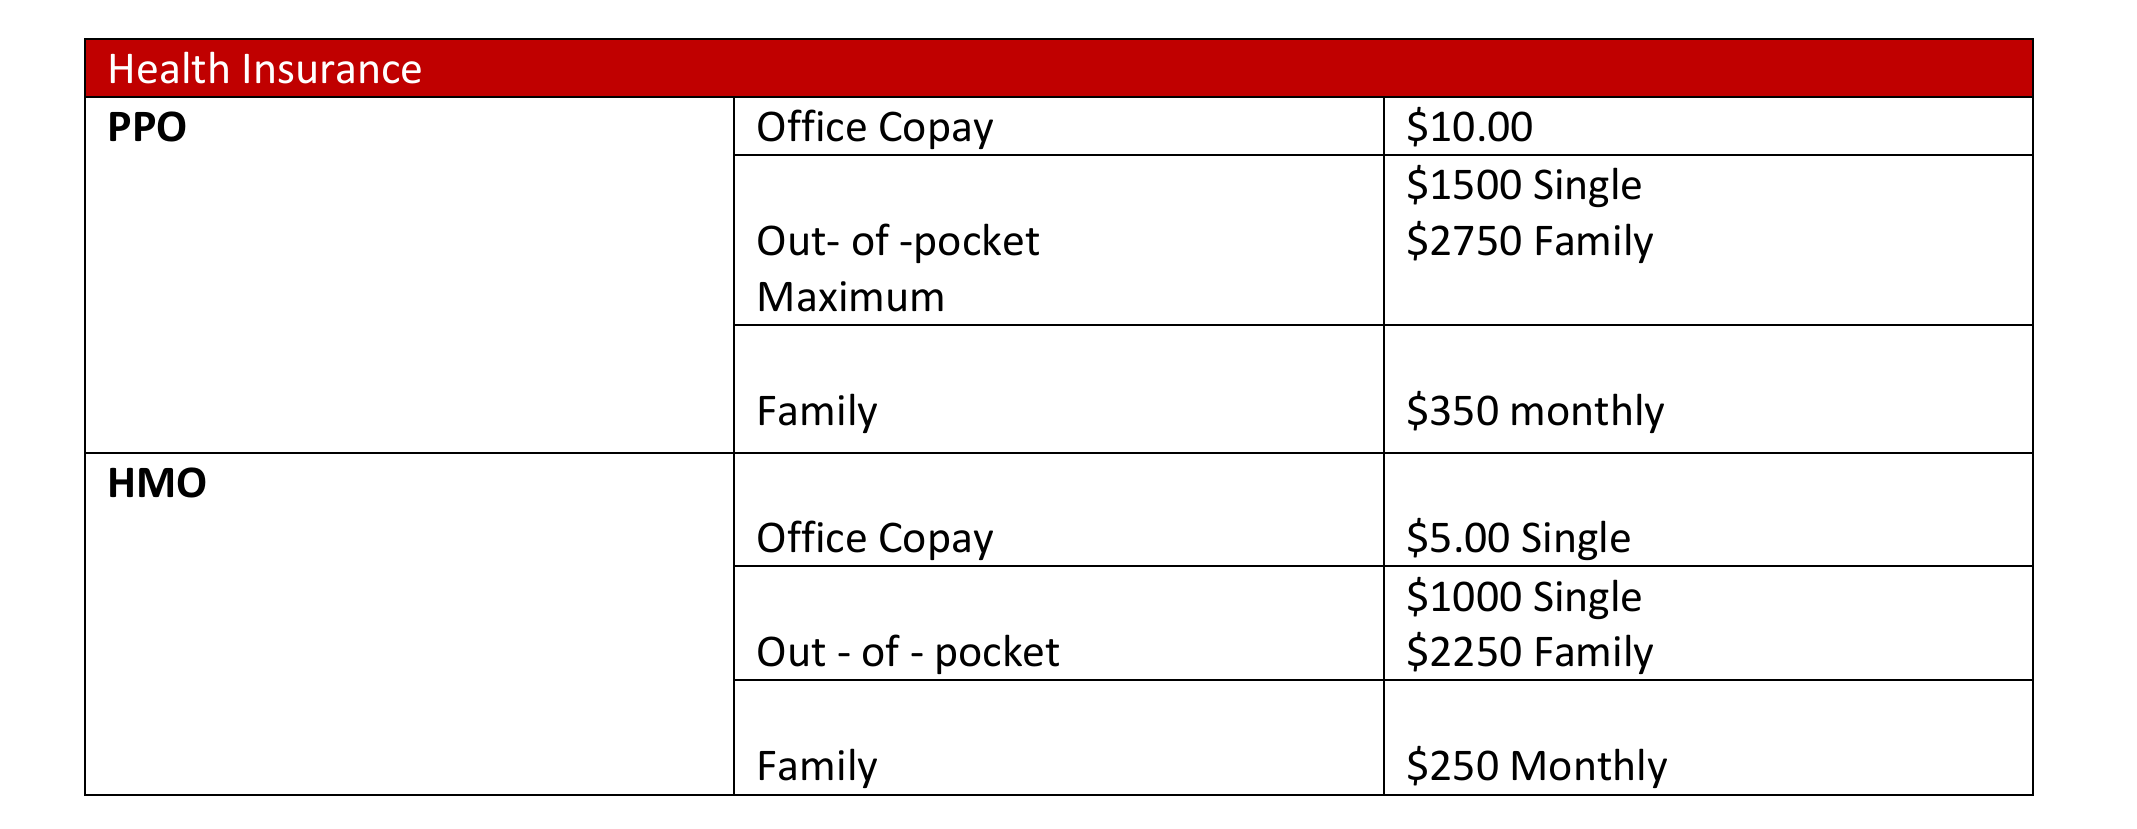

In [39]:
def apply_ocr_tesseract(cell_coordinates, cropped_table_image):
    data = {}
    max_num_columns = 0

    # Apply OCR for each row of the cell coordinates
    for idx, row_data in enumerate(tqdm(cell_coordinates, desc="Applying OCR with Tesseract")):
        row_text = []
        for cell in row_data['cells']:
            x_min, y_min, x_max, y_max = [int(coord) for coord in cell['cell']]
            cell_image = cropped_table_image.crop((x_min, y_min, x_max, y_max))

            # OCR with Tesseract
            text = pytesseract.image_to_string(cell_image, config='--psm 6')
            row_text.append(text.strip())

        max_num_columns = max(max_num_columns, len(row_text))
        data[idx] = row_text

    return data

# OCR
data_tesseract = apply_ocr_tesseract(cell_coordinates, cropped_table)

# Print results row by row
for row, row_data in data_tesseract.items():
    print(row_data)

display(cropped_table)


### Paddle OCR

In [19]:
!pip install paddleocr
!pip install paddlepaddle

from paddleocr import PaddleOCR
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import logging

# Initialise PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Just to stop the debug information from printing
logging.getLogger('ppocr').setLevel(logging.ERROR)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:00<00:00, 4846.78it/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:01<00:00, 9644.42it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:00<00:00, 2936.60it/s]

[2024/11/14 17:58:02] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

['PPO', 'Office Copay', '$10.00']
['', 'Out- of -pocket Maximum', '$1500 Single $2750 Family']
['', 'Family', '$350 monthly']
['HMO', 'Office Copay', '$5.00 Single']
['', 'Out - of - pocket', '$1000 Single $2250 Family']
['', 'Family', '$250 Monthly']


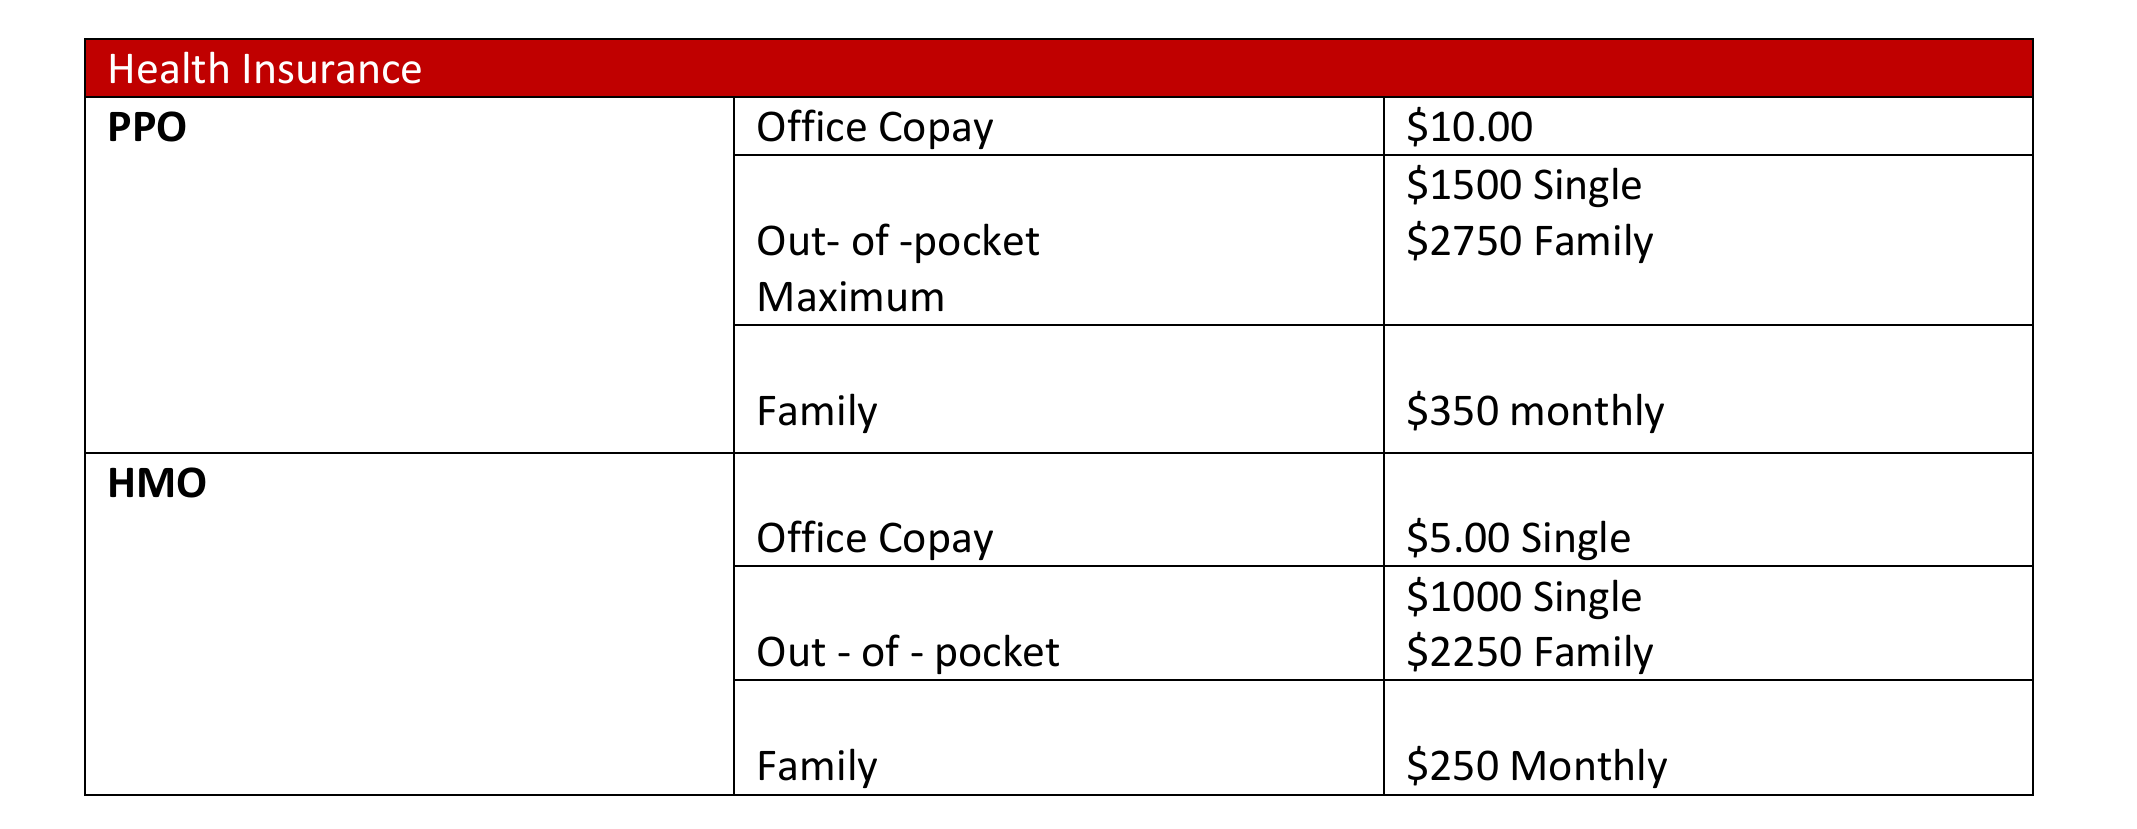

In [40]:
# Apply OCR and collect the output row by row
def apply_ocr_paddle(cell_coordinates, cropped_table_image):
    data = []

    # Apply OCR for each row of the cell coordinates
    for row_data in cell_coordinates:
        row_text = []
        for cell in row_data['cells']:
            x_min, y_min, x_max, y_max = [int(coord) for coord in cell['cell']]
            cell_image = cropped_table_image.crop((x_min, y_min, x_max, y_max))

            # OCR with PaddleOCR
            ocr_result = ocr.ocr(np.array(cell_image), cls=True)
            cell_text = " ".join([line[1][0] for line in ocr_result[0]]) if ocr_result and ocr_result[0] else ""
            row_text.append(cell_text.strip())

        data.append(row_text)

    return data


# Apply OCR and extract text using the cell coordinates
ocr_output = apply_ocr_paddle(cell_coordinates, cropped_table)

# Print OCR results
for row_data in ocr_output:
    print(row_data)

# Display the cropped table image for reference
display(cropped_table)
